In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import copy
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import tqdm
import functools
from scipy import integrate


In [2]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class MLP(nn.Module):
    def __init__(self,
                 in_dim = 1,
                 out_dim = 1,
                 widths = [64, 128, 128, 64]):
        super(MLP, self).__init__()
        
        widths = [in_dim] + list(widths) + [out_dim]
        self.n_layers = len(widths) - 1
        self.layers = nn.ModuleList([nn.Linear(widths[i], widths[i+1]) for i in range(self.n_layers)])
        #self.activation = Swish()#nn.ReLU()
        self.activation = nn.LeakyReLU(inplace=True)
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

#----------------------------

def train(model, optimizer, scheduler, training_loader, val_loader, epochs = 10, loss =  nn.MSELoss(), freq_print = 1, tag = ""):

    best_model_testing_error = 1000

    for epoch in range(epochs):
        train_mse = 0.0
        for step, (input_batch, output_batch) in enumerate(training_loader):
            optimizer.zero_grad()
            output_pred_batch = model(input_batch)
            loss_f = loss(output_pred_batch, output_batch)
            loss_f.backward()
            optimizer.step()
            train_mse += loss_f.item()
        train_mse /= len(training_loader)

        scheduler.step()

        with torch.no_grad():
            model.eval()
            test_relative_l2 = 0.0
            for step, (input_batch, output_batch) in enumerate(val_loader):
                output_pred_batch = model(input_batch)
                loss_f = torch.mean(torch.norm(output_pred_batch - output_batch, p=2, dim = [1]))

                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(val_loader)


        if test_relative_l2 < best_model_testing_error:
            best_model_testing_error = test_relative_l2
            best_model = copy.deepcopy(model)
            torch.save(best_model, f"saved_models/model_1d_{tag}.pkl")

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)

    return best_model
    

In [ ]:
%pip install xitorch

In [3]:
def f_sine(x):
    return np.where(x < 0, np.sin(np.pi*x/2), np.sin(25*np.pi * x))

def get_dataset(N, batch_size=64):
    X = np.random.uniform(-1,1,N)
    Y = f_sine(X).reshape(-1,1)
    X = X.reshape(-1,1)
    return torch.tensor(X).to("cuda").type(torch.float32), torch.tensor(Y).to("cuda").type(torch.float32)


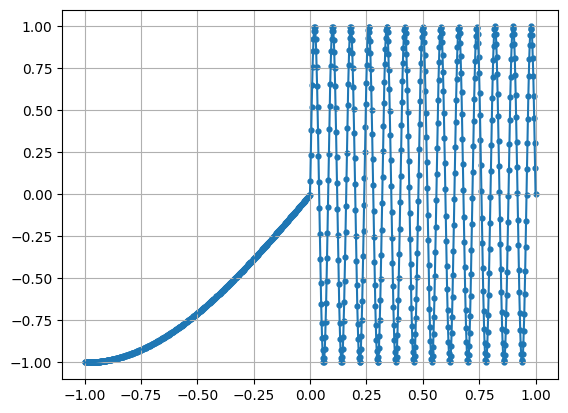

In [4]:
X = np.linspace(-1,1,1000)
plt.scatter(X, f_sine(X), s = 12)
plt.plot(X, f_sine(X))
plt.grid()

In [6]:
batch_size = 128
N_train = 5000
N_val = 1024
N_test = 1024


inp_train, out_train = get_dataset(N_train, batch_size=batch_size)
inp_val, out_val = get_dataset(N_val, batch_size=batch_size)
inp_test, out_test = get_dataset(N_test, batch_size=batch_size)

#-------------

dataset_train = TensorDataset(inp_train, out_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = TensorDataset(inp_val, out_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
weight_decay = 0
step_size = 100
gamma = 0.8
epochs = 500

tag = "tmp"

model = MLP(widths = [64, 64]).to("cuda")
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=50, tag = tag)



######### Epoch: 0  ######### Train Loss: 0.342503347620368  ######### Relative L1 Test Norm: 0.3745548501610756
######### Epoch: 50  ######### Train Loss: 0.24910853281617165  ######### Relative L1 Test Norm: 0.30655672773718834
######### Epoch: 100  ######### Train Loss: 0.24292750731110574  ######### Relative L1 Test Norm: 0.3042878322303295
######### Epoch: 150  ######### Train Loss: 0.23780628778040408  ######### Relative L1 Test Norm: 0.302130626514554
######### Epoch: 200  ######### Train Loss: 0.2432066611945629  ######### Relative L1 Test Norm: 0.3002300150692463
######### Epoch: 250  ######### Train Loss: 0.23244566060602664  ######### Relative L1 Test Norm: 0.2916529159992933
######### Epoch: 300  ######### Train Loss: 0.2245521318167448  ######### Relative L1 Test Norm: 0.2865449748933315
######### Epoch: 350  ######### Train Loss: 0.21867343578487636  ######### Relative L1 Test Norm: 0.28652722761034966
######### Epoch: 400  ######### Train Loss: 0.22559070400893688  #####

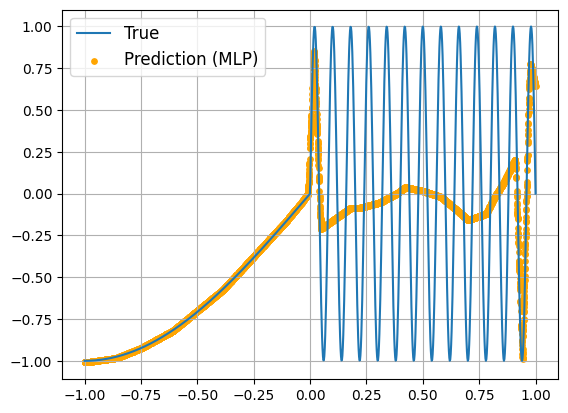

In [7]:

inp_test, out_test = get_dataset(5000)
plt.plot(X, f_sine(X), label = "True")

Y_pred = model(inp_test)[:,0]
plt.scatter(inp_test[:,0].detach().cpu().numpy(), Y_pred.detach().cpu().numpy(), color = "orange", label = "Prediction (MLP)", s = 15)

plt.legend(fontsize = 12)
plt.grid(True)

In [8]:
def marginal_prob_std_1(t, sigma, device = "cuda"):
    """
    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff_1(t, sigma, device = "cuda"):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

def marginal_prob_std_2(t, sigma_min, sigma_max, device = "cuda"):
    """
    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    t = torch.tensor(t, device=device)
    #print(torch.sqrt(sigma_min * torch.pow(sigma_max/sigma_min, t)))
    return sigma_min * torch.pow(sigma_max/sigma_min, t)

def diffusion_coeff_2(t, sigma_min, sigma_max, device = "cuda"):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma_min * torch.pow(sigma_max/sigma_min, t) * np.sqrt(2*np.log(sigma_max/sigma_min)), device=device)

#----------------------

class MLPDiffusion(nn.Module):
    def __init__(self,
                 in_dim = 1,
                 out_dim = 1,
                 cond_dim = 0,
                 widths = [64, 128, 128, 64],
                 marginal_prob_std = None):
        super(MLPDiffusion, self).__init__()
        
        widths = [in_dim + 1 + cond_dim] + list(widths) + [out_dim]
        self.n_layers = len(widths) - 1
        self.layers = nn.ModuleList([nn.Linear(widths[i], widths[i+1]) for i in range(self.n_layers)])
        self.activation = nn.SiLU()

        self.marginal_prob_std = marginal_prob_std


    def forward(self, 
                x,
                x_cond,
                diffusion_time):
        
        sigma = self.marginal_prob_std(diffusion_time)
        #sigma = torch.log(sigma) + 1/2.

        if sigma.dim() < 1:
            sigma = sigma.expand(x.shape[0])
        
        if x_cond is not None:
            x = torch.cat((x, x_cond, torch.log(sigma)[:, None]), dim=1)
        else:
            x = torch.cat((x, torch.log(sigma)[:, None]), dim=1)
        
        
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x/sigma[:,None]

In [9]:
def loss_fn(model, 
            x, 
            x_cond,
            marginal_prob_std = None, 
            eps=1e-6,
            is_train = True):

        if is_train:
                random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps    
                z = torch.randn_like(x, device = x.device)    
                std = marginal_prob_std(random_t) 
                denoised = model(x + z * std[:, None], x_cond, random_t)

                x_squared = torch.square(x)
                denoise_squared = torch.square(denoised)
                loss = torch.mean(torch.square(denoised - x))
                return loss
        else:
                err_val = 0
                for level in range(8):
                        t_min = level/8.0
                        t_max = (level + 1)/8.0
                        random_t = (torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps )*(t_max-t_min)+t_min
                        
                        z = torch.randn_like(x)
                        std = marginal_prob_std(random_t) 

                        denoised = model(x + z * std[:, None], x_cond, random_t)
                        loss = torch.mean(torch.square(denoised - x))
                        err_val = err_val + loss
                return err_val/8.0

In [19]:
def Euler_Maruyama_sampler(model,
                           marginal_prob_std,
                           diffusion_coeff,
                           condition,
                           batch_size=64,
                           num_steps=128,
                           device='cuda',
                           dimension = (2,),
                           eps=1e-4):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """

  device = next(model.parameters()).device

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, dimension[0], device=device) * marginal_prob_std(t).to(device)[:, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        g = diffusion_coeff(batch_time_step).to(device)
        #score = model(x, condition, batch_time_step)
        denoised = model(x, condition, batch_time_step)
        std = marginal_prob_std(batch_time_step)
        score = (denoised - x)/std[:, None]**2
        mean_x = x + (g**2)[:, None] * score * step_size
        x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        
  return mean_x

In [20]:
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                condition = None,
                batch_size=64,
                atol=1e-5,
                rtol=1e-5,
                device='cuda',
                z=None,
                dimension = (2,),
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """

  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, dimension[0], device=device) * marginal_prob_std(t)[:, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    score_model.train()
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    denoised = score_model(sample, None, time_steps)
    std = marginal_prob_std(time_steps)
    
    #score = (denoised - sample)/std[:, None]**2
    
    return ((denoised - sample)/std[:, None]**2).detach().cpu().numpy().reshape((-1))

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


In [49]:
from torch.func import vmap, jvp
from xitorch import integrate as integrate_torch

def prior_likelihood_torch(z, sigma):  
    """The likelihood of a Gaussian distribution with mean zero and
      standard deviation sigma."""
    shape = z.shape
    N = torch.prod(torch.tensor(shape[1:], device=device))
    dim = [i for i in range(1, len(shape))]
    return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=dim) / (2 * sigma**2)


def ode_likelihood_torch(model,
                        x,
                        condition,
                        marginal_prob_std,
                        diffusion_coeff,
                        t_batch = None,
                        batch_size=64,
                        device='cuda',
                        eps = 1e-6,
                        rtol = 1e-6,
                        atol = 1e-6,
                        epsilon = None):

    shape = x.shape
    B,C = shape[0], torch.tensor(shape[1:], device=device)
    shape_epsilon = (batch_size,)+shape[1:] 

    def divergence_eval(fn, x, epsilon):
        """Compute the divergence of the score-based model with Skilling-Hutchinson."""

        epsilon.requires_grad_(True)
        x.requires_grad_(True)
        f_e = lambda x, eps: torch.sum(fn(x).reshape(B,C) * eps.view(1,-1), dim=-1) # shape (B,)

        def e_Jf_e(eps):
            _, jvp_result = jvp(f_e, (x, eps), (eps.repeat(B,1), torch.zeros_like(eps)))
            return jvp_result

        e_Jf_e_multisample = vmap(e_Jf_e, out_dims=1) # allow additional "batch-dimension" for eps (this is sample_size)
        res = e_Jf_e_multisample(epsilon)
        return res.mean(dim=1)

    def ode_func(t, x):
        """The ODE function for the black-box solver."""
        time_steps = torch.ones((shape[0],), device = device) * t   
        sample = x[:B*C]
        logp = x[B*C:]
        g = diffusion_coeff(torch.tensor(t, device=device))
        
        sample = sample.reshape(shape)  # Convert to tensor
        time_steps = time_steps.reshape((sample.shape[0],))

        std = marginal_prob_std(time_steps)[(slice(None),) + (None,) * (len(shape) - 1)]
        model.train()
        fn = lambda x: (model(x, condition, time_steps.reshape((B,))) - x.reshape(shape)) / std**2

        logp_grad = -0.5 * g**2 * divergence_eval(fn, sample, epsilon)
        sample_grad = -0.5 * g**2 * fn(sample)
        
        return torch.cat([sample_grad.reshape(-1), logp_grad.reshape(-1)], axis = 0)


    init = torch.cat([x.view(-1), torch.zeros(shape[0], device=device)])    
    res = integrate_torch.solve_ivp(fcn = ode_func, y0=init, ts = torch.tensor([eps, 1.0], device=device), rtol=rtol, atol=atol, method="rk45")
    zp = res[-1]
    
    z, delta_logp = zp[:B*C], zp[B*C:]
    z = z.reshape((B,C))

    sigma_max = marginal_prob_std(torch.tensor(1.0, device=device))
    prior_logp = prior_likelihood_torch(z, sigma_max)

    N = torch.prod(torch.tensor(shape[1:], device=device))
    
    return z, prior_logp/N, delta_logp/N


In [32]:
'''
  You can skip the training and load the model in the next field.
'''

learning_rate = 0.001
step_size = 50
gamma = 0.95
epochs = 10000
device = "cuda"

tqdm_epoch = tqdm.trange(epochs)

save_epochs = [100, 1000, 2000, 5000, 9999]

which_type = "x&y"
if which_type == "x&y":
  cond_dim = 0
  in_dim = 2
else:
  cond_dim = 1
  in_dim = 1

sigma = 100.

marginal_prob_std_fn = functools.partial(marginal_prob_std_2, sigma_min = 0.001, sigma_max=sigma, device = device)
diffusion_coeff_fn = functools.partial(diffusion_coeff_2, sigma_min = 0.001, sigma_max=sigma, device = device)

model_diff = MLPDiffusion(widths = [1024, 1024, 1024], marginal_prob_std = marginal_prob_std_fn, cond_dim=cond_dim, in_dim=in_dim, out_dim=in_dim).to("cuda")
optimizer = AdamW(model_diff.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

best_avg_loss = 1000.
best_model_diff = None

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    avg_loss_val = 0.

    model_diff.train()

    for input_batch, output_batch in dataloader_train:
      input_batch = input_batch.to(device)
      output_batch = output_batch.to(device)

      if which_type == "yx":
        loss = loss_fn(model_diff, output_batch, input_batch, marginal_prob_std_fn)
        condition = input_batch
      elif which_type == "x&y":
        loss = loss_fn(model_diff, torch.cat((input_batch, output_batch), axis = 1), None, marginal_prob_std_fn)
        condition = None
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_loss += loss.item() * output_batch.shape[0]
      num_items += output_batch.shape[0]
    avg_loss /= num_items

    scheduler.step()

    model_diff.eval()
    
    num_items = 0
    with torch.no_grad():
        for input_batch, output_batch in dataloader_val:
          input_batch = input_batch.to(device)
          output_batch = output_batch.to(device)

          if which_type == "yx":
            loss = loss_fn(model_diff, output_batch, input_batch, marginal_prob_std_fn, is_train = False)
          elif which_type == "x&y":
            loss = loss_fn(model_diff, torch.cat((input_batch, output_batch), axis = 1), None, marginal_prob_std_fn, is_train = False)
          avg_loss_val += loss.item() * output_batch.shape[0]
          num_items += output_batch.shape[0]
    avg_loss_val/= num_items

    
    if avg_loss_val<best_avg_loss:
      best_avg_loss = avg_loss_val    
      best_model_diff = copy.deepcopy(model_diff)
    

    if epoch in save_epochs:
      torch.save(best_model_diff.state_dict(), f"saved_models/diff_model1d_ep_{epoch}.pth")

    if epoch%10 == 0:
      tqdm_epoch.set_description('Train: {:.5f} Val: {:.5f}'.format(avg_loss, avg_loss_val))
    

  0%|          | 0/5001 [00:00<?, ?it/s]/scratch/tmp.43630062.braonic/ipykernel_1677108/3935541340.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Train: 0.15897 Val: 0.15817: 100%|██████████| 5001/5001 [08:32<00:00,  9.75it/s]  


/scratch/tmp.43630062.braonic/ipykernel_1677108/3935541340.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/512 [00:00<?, ?it/s]/scratch/tmp.43630062.braonic/ipykernel_1677108/3935541340.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma_min * torch.pow(sigma_max/sigma_min, t) * np.sqrt(2*np.log(sigma_max/sigma_min)), device=device)
100%|██████████| 512/512 [00:00<00:00, 2714.59it/s]


Number of function evaluations: 206


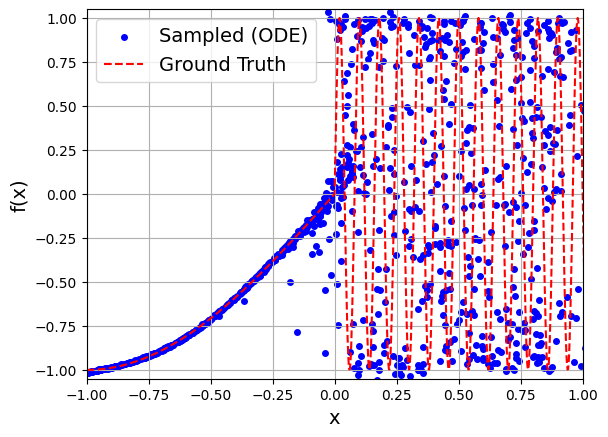

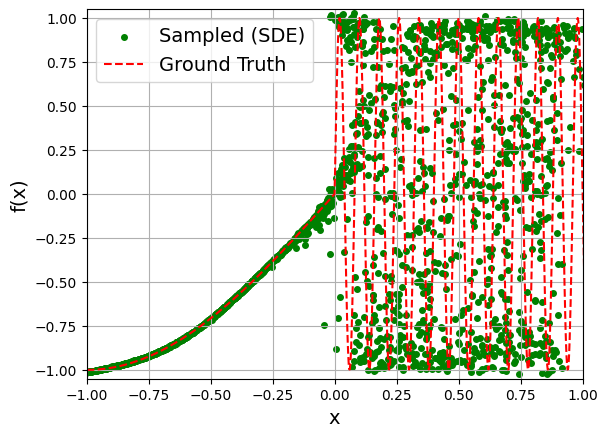

In [50]:
sigma = 100.
cond_dim = 0
in_dim = 2
marginal_prob_std_fn = functools.partial(marginal_prob_std_2, sigma_min = 0.001, sigma_max=sigma, device = device)
diffusion_coeff_fn = functools.partial(diffusion_coeff_2, sigma_min = 0.001, sigma_max=sigma, device = device)

path =  "/cluster/home/braonic/ood_detection_jlbc/ood_generalization/1d_notebooks/saved_models/diff_model1d_ep_9999.pth"
device = "cuda"
model_best = MLPDiffusion(widths = [1024, 1024, 1024], marginal_prob_std = marginal_prob_std_fn, cond_dim=cond_dim, in_dim=in_dim, out_dim=in_dim).to("cuda")
model_best.load_state_dict(torch.load(path, map_location=device, weights_only=True))
model_best.eval()


samples_sde = Euler_Maruyama_sampler(model_best,
                                marginal_prob_std_fn,
                                diffusion_coeff_fn,
                                None,
                                batch_size=2048,
                                num_steps=512,
                                device='cuda',
                                dimension = (2,),
                                eps=1e-10)

samples_ode = ode_sampler(model_best,
                marginal_prob_std_fn,
                diffusion_coeff_fn,
                condition = None,
                batch_size=1024,
                atol=1e-6,
                rtol=1e-6,
                device='cuda',
                z=None,
                dimension = (2,),
                eps=1e-10)

plt.scatter(samples_ode[:,0].detach().cpu().numpy(),samples_ode[:,1].detach().cpu().numpy(), color = "blue", s = 16, label = "Sampled (ODE)")
X = np.linspace(-1,1.05,1000)
plt.plot(X, f_sine(X), "--", color = "red", label = "Ground Truth")
plt.grid()

plt.xlim([-1,1])
plt.ylim([-1.05,1.05])
plt.legend(fontsize=14)

plt.xlabel("x",fontsize=14)
plt.ylabel("f(x)",fontsize=14)
plt.show()

plt.scatter(samples_sde[:,0].detach().cpu().numpy(),samples_sde[:,1].detach().cpu().numpy(), color = "green", s = 16, label = "Sampled (SDE)")
X = np.linspace(-1,1.05,1000)
plt.plot(X, f_sine(X), "--", color = "red", label = "Ground Truth")
plt.grid()

plt.xlim([-1,1])
plt.ylim([-1.05,1.05])
plt.legend(fontsize=14)

plt.xlabel("x",fontsize=14)
plt.ylabel("f(x)",fontsize=14)

plt.show()


In [54]:
from torch.utils.data import TensorDataset, DataLoader

S = 64  # Example resolution
step_size = (1/(S))

# Generate 1D grid points
l = 1.0
x = np.arange(-l, l, step_size*(l))
y = np.arange(-l, l, step_size*(l))

# Create 2D grid
xx, yy = np.meshgrid(x, y, indexing='ij')
print(xx.shape)
# Stack coordinates
coordinates = np.column_stack([xx.ravel(), yy.ravel()])
coordinates = torch.tensor(coordinates).to("cuda").type(torch.float32)

device = "cuda"
model_best = MLPDiffusion(widths = [1024, 1024, 1024], marginal_prob_std = marginal_prob_std_fn, cond_dim=cond_dim, in_dim=in_dim, out_dim=in_dim).to("cuda")
model_best.load_state_dict(torch.load(path, map_location=device, weights_only=True))


# Create a dataset
dataset = TensorDataset(coordinates)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

# Iterate over the DataLoader

batch_size = 32
epsilon = torch.randn((batch_size, 2), device = device).type(torch.float32)
epsilon = torch.sqrt(torch.prod(torch.tensor(2, device=device))) * epsilon / torch.norm(epsilon, dim=1, keepdim=True)
for i, batch in enumerate(dataloader):
    print(i, len(dataloader))
    x_, prior_, delta_ = ode_likelihood_torch(model= model_best,
                                            x = batch[0],
                                            condition = None,
                                            marginal_prob_std = marginal_prob_std_fn,
                                            diffusion_coeff = diffusion_coeff_fn,
                                            batch_size = batch_size,
                                            device='cuda',
                                            eps = 1e-8,
                                            rtol = 1e-2,
                                            atol = 1e-2,
                                            epsilon = epsilon)
                        
    if i == 0:
        x, prior, delta = x_.detach().cpu().numpy(), prior_.detach().cpu().numpy(), delta_.detach().cpu().numpy()
    else:
        x = np.concatenate((x, x_.detach().cpu().numpy()))
        prior = np.concatenate((prior, prior_.detach().cpu().numpy()))
        delta = np.concatenate((delta, delta_.detach().cpu().numpy()))


(128, 128)
0 64


/scratch/tmp.43630062.braonic/ipykernel_1677108/4205296032.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g = diffusion_coeff(torch.tensor(t, device=device))
/scratch/tmp.43630062.braonic/ipykernel_1677108/3935541340.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma_min * torch.pow(sigma_max/sigma_min, t) * np.sqrt(2*np.log(sigma_max/sigma_min)), device=device)
/scratch/tmp.43630062.braonic/ipykernel_1677108/3935541340.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device

1 64
2 64
3 64
4 64
5 64
6 64
7 64
8 64
9 64
10 64
11 64
12 64
13 64
14 64
15 64
16 64
17 64
18 64
19 64
20 64
21 64
22 64
23 64
24 64
25 64
26 64
27 64
28 64
29 64
30 64
31 64
32 64
33 64
34 64
35 64
36 64
37 64
38 64
39 64
40 64
41 64
42 64
43 64
44 64
45 64
46 64
47 64
48 64
49 64
50 64
51 64
52 64
53 64
54 64
55 64
56 64
57 64
58 64
59 64
60 64
61 64
62 64
63 64


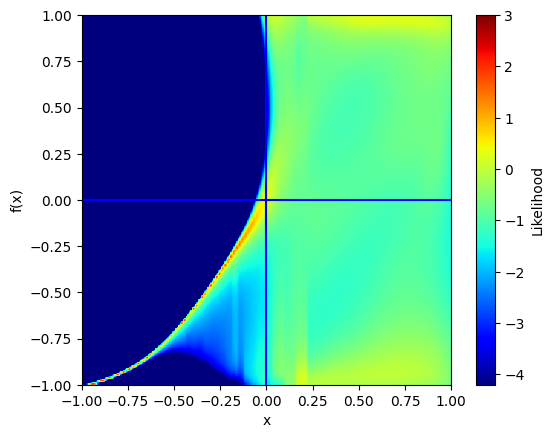

In [55]:
#heatmap = bpd[bpd>-4]
#plt.plot(heatmap[:,0])

likelihood = prior + delta
heatmap = likelihood.reshape((2*S,2*S))

plt.imshow(heatmap.T, extent=[-l, l, -l, l], origin="lower", cmap="jet", vmin = 2 - 6.2, vmax = 8-5)
plt.colorbar(label="Likelihood")
plt.xlabel("x")
plt.ylabel("f(x)")
#plt.title("Heatmap of Values")
plt.plot([0,0],[-l,l], color = "blue")
plt.plot([-l,l],[0,0], color = "blue")

X = np.linspace(-min(l,l),0,1000)
#plt.plot(X, f_sine(X), "--", color = "black")
plt.xlim([-l, l])
plt.ylim([-l, l])


#plt.savefig("Figures/1d_diffusion/sines/estimated_likelihoods.pdf", dpi = 400)
#plt.savefig("Figures/1d_diffusion/sines/estimated_likelihoods.png", dpi = 400)

plt.show()